In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import PIL

np.random.seed(7)
%matplotlib inline

print(tf.__version__)

2.2.0


**Image Overview**

In [2]:
content_path = '/content/drive/My Drive/style_transfer/person.jpg'
style_path = '/content/drive/My Drive/style_transfer/cartoon.jpg'

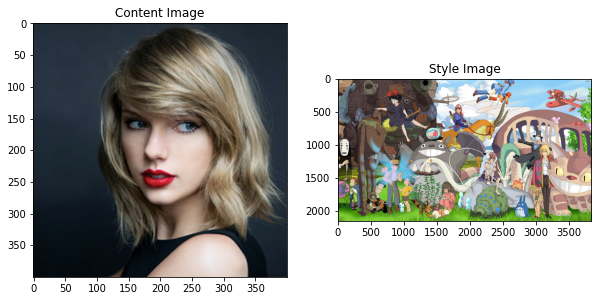

In [3]:
# Load the content and style images
content = plt.imread(content_path)
style = plt.imread(style_path)

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

**Preprocessing image**
*   Specify the scale of image.
*   Loads an image into PIL format.
*   Rescale an image.
*   Converts a PIL Image instance to a Numpy array.
*   Add a new dimensoin for number of sample.
*   Adequate the image to the format the model requires.

In [4]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [5]:
# Verify the shapes
# Load the content and style images
content = load_image(content_path)
style = load_image(style_path)

content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

**Building the VGG19 model**
*   Load pre-trained VGG19 model without top layer.
*   Freeze weight.
*   Specify the intermediate layers for content and style of the image.

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Specify the intermidate layers for content and style**
* For content, it cares about features so that we select last blocks.
* For style, it cares about textures so that we select intermidate blocks.

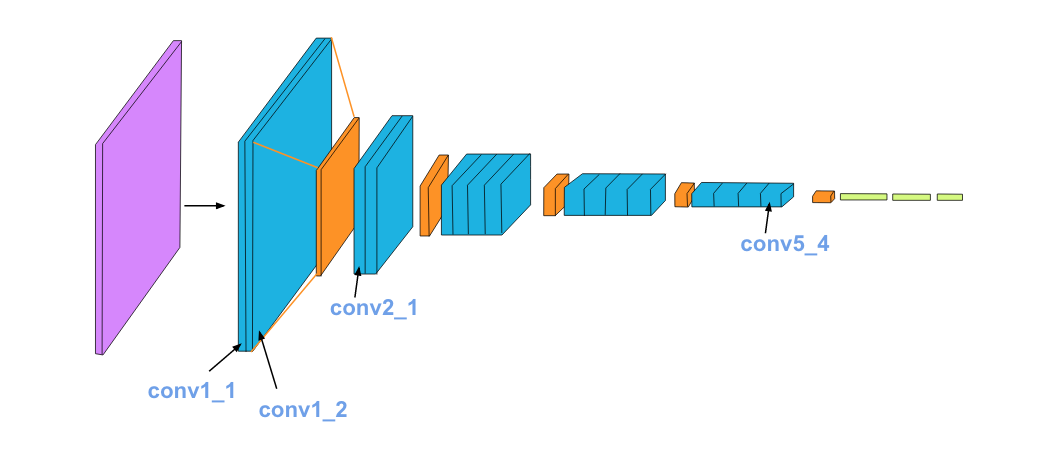

In [7]:
# Naming rules, for example, conv1_2 means that filter #2 in block #1 
Image("/content/drive/My Drive/style_transfer/img/VGG19.jpg", width=600)

In [8]:
# Choose intermediate layers from the network to represent the style and content of the image

# Content layer
content_layers = ['block5_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
# We create this function to extract output later
def mini_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

**Calculate Loss**
*   Gram matrix
*   Content loss
*   Style loss
*   Total loss

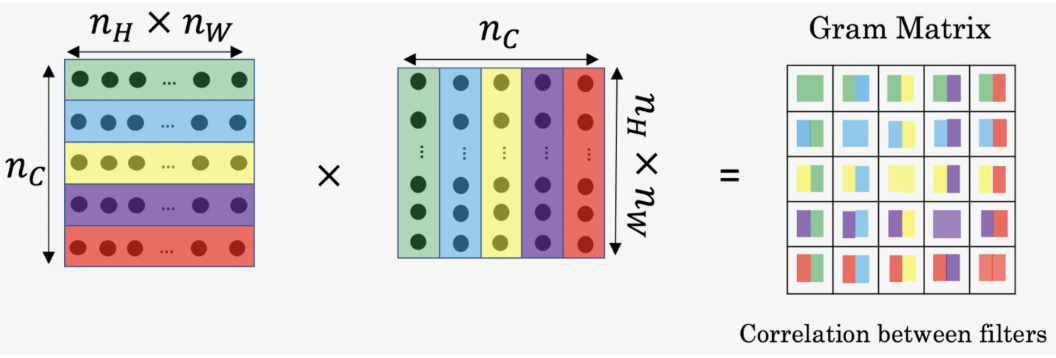

In [10]:
Image("/content/drive/My Drive/style_transfer/img/gram.jpg", width=500)

In [11]:
"""
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram
"""

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

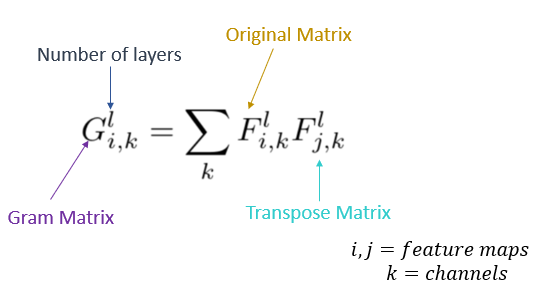

In [12]:
Image("/content/drive/My Drive/style_transfer/img/gram_2.jpg", width=500)

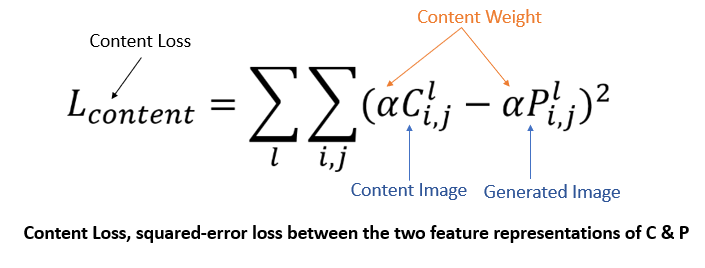

In [13]:
Image("/content/drive/My Drive/style_transfer/img/content_loss.jpg", width=500)

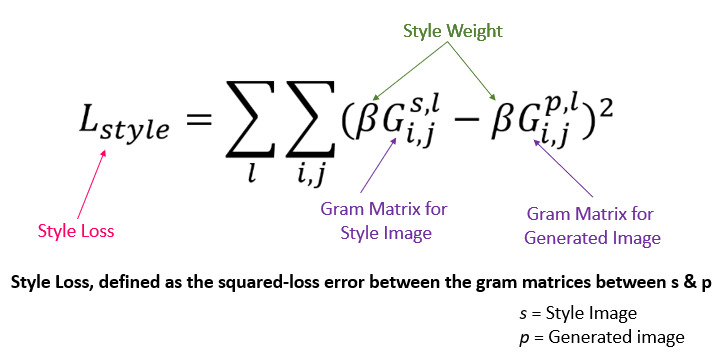

In [14]:
Image("/content/drive/My Drive/style_transfer/img/style_loss.jpg", width=500)

In [15]:
# The loss function to optimize
def total_loss(outputs):
    # Output
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Style loss and content loss
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    style_loss *= style_weight / num_style_layers
    
    return style_loss + content_loss

**Custom Model**

In [16]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False # Freeze the weight

  def call(self, inputs):
    # Scale back the pixel values (When load image file, tf.image.convert_image_dtype makes value between [0,1])
    inputs = inputs*255.0
    # Adequate the image to the format the model requires
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assign the content representation and gram matrix in a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [17]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [18]:
# Create optimier
opt = tf.optimizers.Adam(learning_rate=0.02)

In [19]:
# Custom weights for style and content updates
style_weight=100
content_weight=10


# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [20]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [21]:
target_image = tf.Variable(content)

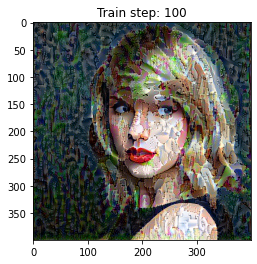

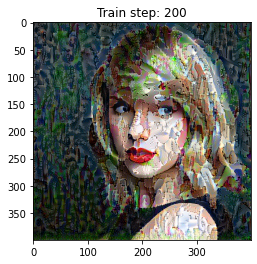

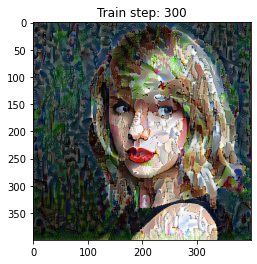

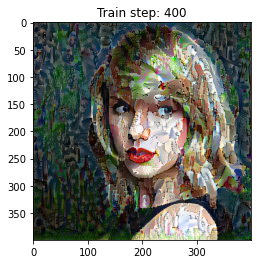

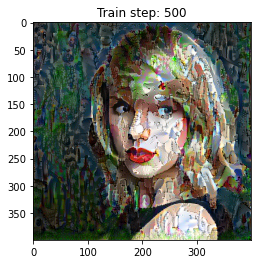

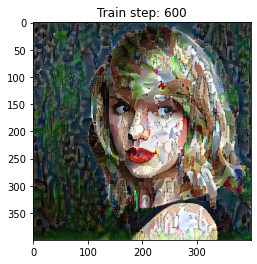

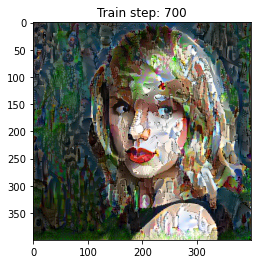

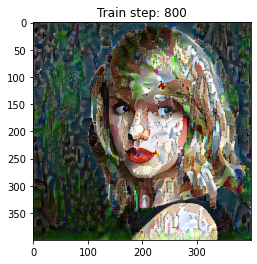

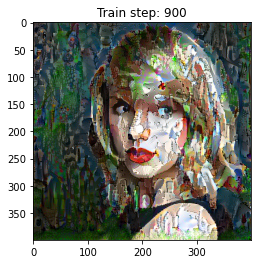

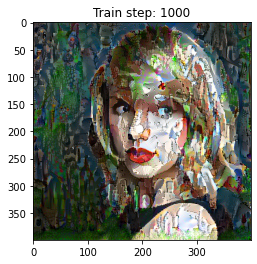

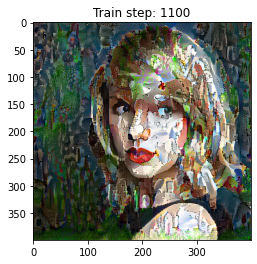

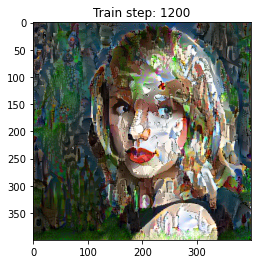

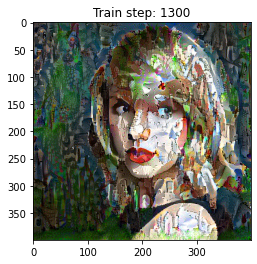

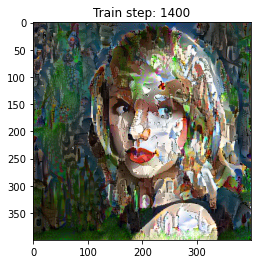

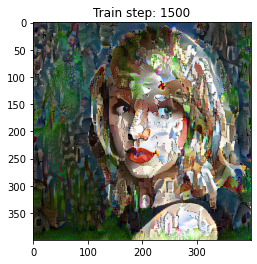

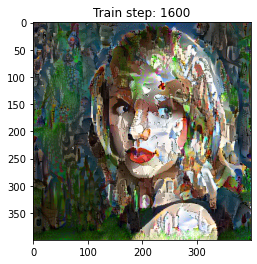

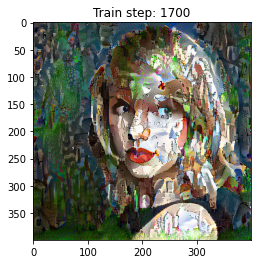

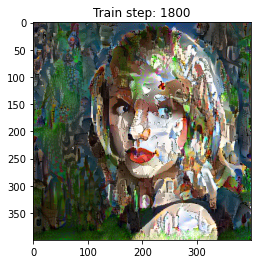

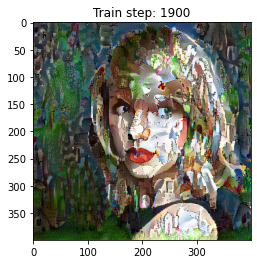

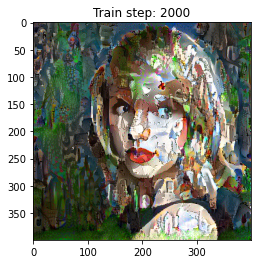

In [22]:
epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

**Fast Neural Style Transfer**

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

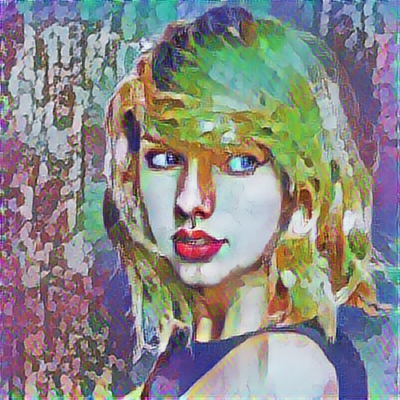

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content), tf.constant(style))[0]
tensor_to_image(stylized_image)

**Neural Style Transfer for Video**

In [ ]:
content_path = '/content/drive/My Drive/style_transfer/content_image/'
style_path = '/content/drive/My Drive/style_transfer/style_image/'
frame_dir_path = '/content/drive/My Drive/style_transfer/frame_image/'

In [ ]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

**Helper functions to split a video into image frames for style transfer, and then to combine the stylized images back to video**

In [ ]:
# Extract images from a video
import cv2
print(cv2.__version__)

# Load a video from the following path
videoDir='/content/drive/My Drive/style_transfer/video.mp4'

# Split a video into frames and save at the following path
imgDir='/content/drive/My Drive/style_transfer/video_frame/'

vidcap = cv2.VideoCapture(videoDir)
print (vidcap.read())
success,image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  #print ('Read a new frame: ', success)
  if success == True:
    cv2.imwrite(imgDir+"frame%d.jpg" % count, image)     # save frame as JPEG file
    print ('Save as a new frame: frame%d.jpg ' % count)
    count += 1
  else:
    break

4.1.2
(True, array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))
Save as a new frame: frame0.jpg 
Save as a new frame: frame1.jpg 
Save as a new frame: frame2.jpg 
Save as a new frame: frame3.jpg 
Save as a new frame: frame4.jpg 
Save as a new frame: 

In [ ]:
# Save all style-transferred frames to following path
frame_dir_path = '/content/drive/My Drive/style_transfer/frame_image/'

# Style transfer for each frame
import os
frames_list=os.listdir(imgDir)
style_image=load_image(os.path.join(style_path,'cartoon.jpg')  )
epochs=2
for frame in frames_list:
  print('process images: ', frame)
  content_image = load_image(os.path.join(imgDir,frame))
  stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
  img=tensor_to_image(stylized_image)    
  img.save(os.path.join(frame_dir_path,frame))

process images:  frame0.jpg
process images:  frame1.jpg
process images:  frame2.jpg
process images:  frame3.jpg
process images:  frame4.jpg
process images:  frame5.jpg
process images:  frame6.jpg
process images:  frame7.jpg
process images:  frame8.jpg
process images:  frame9.jpg
process images:  frame10.jpg
process images:  frame11.jpg
process images:  frame12.jpg
process images:  frame13.jpg
process images:  frame14.jpg
process images:  frame15.jpg
process images:  frame16.jpg
process images:  frame17.jpg
process images:  frame18.jpg
process images:  frame19.jpg
process images:  frame20.jpg
process images:  frame21.jpg
process images:  frame22.jpg
process images:  frame23.jpg
process images:  frame24.jpg
process images:  frame25.jpg
process images:  frame26.jpg
process images:  frame27.jpg
process images:  frame28.jpg
process images:  frame29.jpg
process images:  frame30.jpg
process images:  frame31.jpg
process images:  frame32.jpg
process images:  frame33.jpg
process images:  frame34

In [ ]:
# Assemble images into a video
import cv2
import os

# Load all style-transferred frames from the following path
image_folder = '/content/drive/My Drive/style_transfer/frame_image/'

# Save converted video at the following path
video_name = image_folder+'/video_out.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

**Reference**


*   https://www.kaggle.com/basu369victor/style-transfer-deep-learning-algorithm
*   https://www.pluralsight.com/guides/implementing-artistic-neural-style-transfer-with-tensorflow-2.0
*   https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow
*   https://www.tensorflow.org/tutorials/generative/style_transfer